In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')


In [3]:
images = glob('train_cancer/*/*.jpg')
len(images)


270

In [4]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()


,filepath,label
0,train_cancer/benign/12.jpg,benign
1,train_cancer/benign/13.jpg,benign
2,train_cancer/benign/14.jpg,benign
3,train_cancer/benign/17.jpg,benign
4,train_cancer/benign/19.jpg,benign


In [5]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()


,filepath,label,label_bin
0,train_cancer/benign/12.jpg,benign,0
1,train_cancer/benign/13.jpg,benign,0
2,train_cancer/benign/14.jpg,benign,0
3,train_cancer/benign/17.jpg,benign,0
4,train_cancer/benign/19.jpg,benign,0


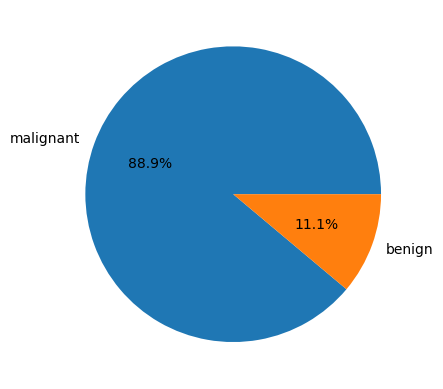

In [6]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()


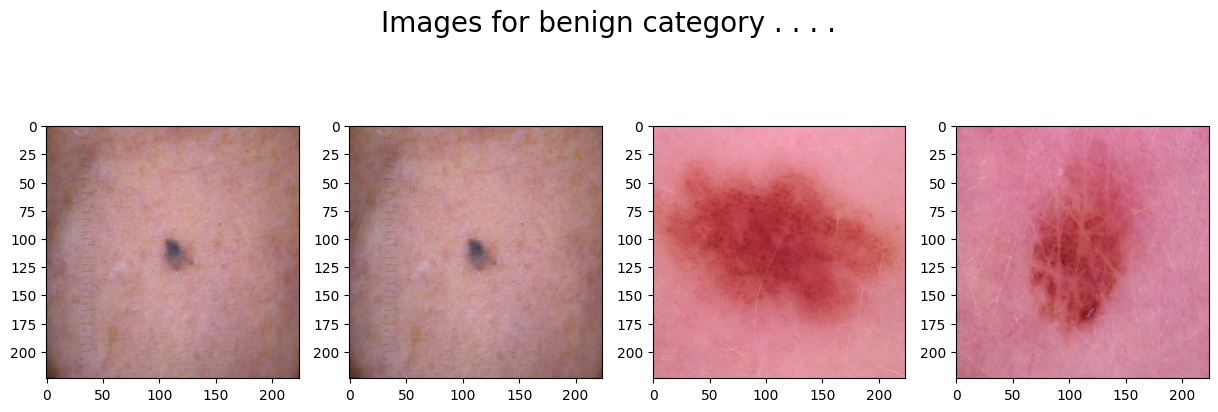

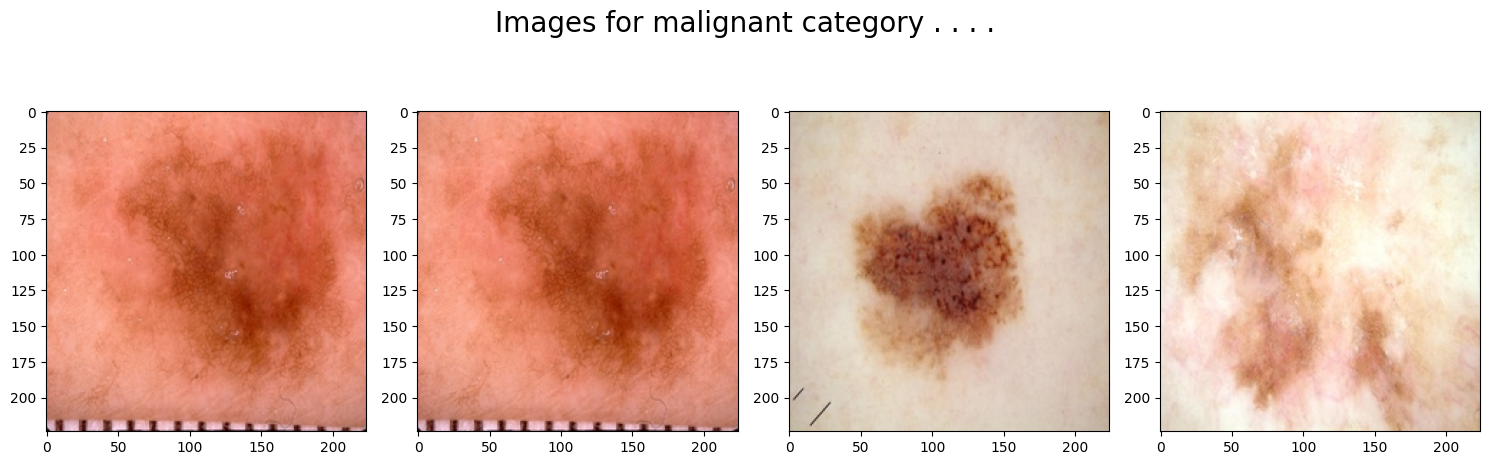

In [7]:
for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()


In [8]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape


((229,), (41,))

In [9]:
import tensorflow as tf

def decode_image(filepath, label=None):
    # Read and decode the image
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    # Convert the label to numerical value
    if label is not None and isinstance(label, str):
        if label == 'benign':
            label = 0
        else:
            label = 1
    else:
        label = None

    return img, label


In [10]:
## 2

import tensorflow as tf

def decode_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming RGB images
    img = tf.image.resize(img, [224, 224])  # Resize if necessary
    img = tf.cast(img, tf.float32) / 255.0  # Normalize pixel values
    
    return img, label

# Assuming X_train, Y_train, X_val, Y_val contain file paths and labels
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


In [11]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3),
	weights='imagenet',
	include_top=False
)

for layer in pre_trained_model.layers:
	layer.trainable = False


In [12]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


In [13]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC']
)


In [14]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=15,
					verbose=1)


Epoch 1/15


4/4 [==============================] - 3s 358ms/step - loss: 0.8795 - auc: 0.6962 - val_loss: 0.4749 - val_auc: 0.5946
Epoch 2/15
4/4 [==============================] - 1s 261ms/step - loss: 0.6956 - auc: 0.8253 - val_loss: 0.6176 - val_auc: 0.6149
Epoch 3/15
4/4 [==============================] - 1s 272ms/step - loss: 0.5590 - auc: 0.9191 - val_loss: 0.7733 - val_auc: 0.9865
Epoch 4/15
4/4 [==============================] - 1s 270ms/step - loss: 0.5035 - auc: 0.9419 - val_loss: 0.4154 - val_auc: 0.9865
Epoch 5/15
4/4 [==============================] - 1s 289ms/step - loss: 0.4512 - auc: 0.9690 - val_loss: 0.0889 - val_auc: 1.0000
Epoch 6/15
4/4 [==============================] - 1s 285ms/step - loss: 0.4308 - auc: 0.9547 - val_loss: 0.0709 - val_auc: 0.9932
Epoch 7/15
4/4 [==============================] - 1s 292ms/step - loss: 0.3870 - auc: 0.9704 - val_loss: 0.1349 - val_auc: 1.0000
Epoch 8/15
4/4 [==============================] - 1s 295ms/step - loss: 0.3378 - auc: 0.

In [15]:
hist_df = pd.DataFrame(history.history)
hist_df.head()


,loss,auc,val_loss,val_auc
0,0.879521,0.696192,0.474903,0.594595
1,0.695639,0.825313,0.617621,0.614865
2,0.559018,0.919098,0.773289,0.986486
3,0.503509,0.941929,0.415442,0.986486
4,0.451216,0.969022,0.088946,1.000000


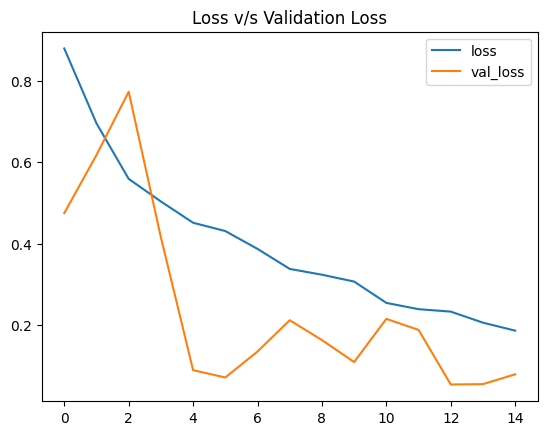

In [16]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()


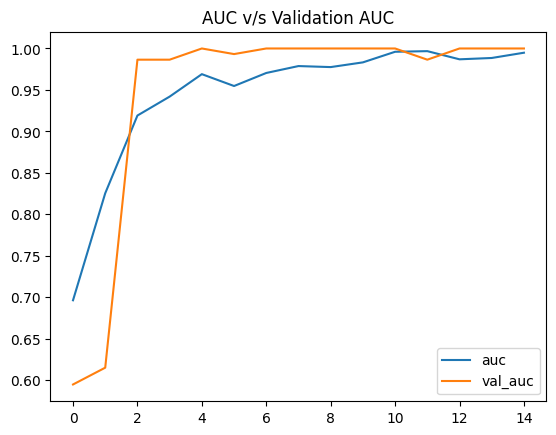

In [17]:
hist_df['auc'].plot()
hist_df['val_auc'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()


In [18]:
import tensorflow as tf


model.save('my_model')



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets
